# Graduate Project of CNN Regression version 2.5 - XGBoost Regression

## Initialize machine learning library

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
print(torch.__version__)

2.6.0+cpu


### Set computing device as CPU

In [2]:
device = torch.device("cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Data load in and pre-processing

In [6]:
features = pd.read_csv("../../data/data.csv", header=None)
features = features.transpose()
# features = data.values.T.astype(np.float32)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,500,501,502,503,504,505,506,507,508,509
0,70.0,200.0,300.0,28.801196,81.105366,6125.0,5690.0,6560.0,870.0,-120.782809,...,-118.949780,-118.499691,-118.020283,-117.503018,-116.936596,-116.305609,-115.588315,-114.752730,-113.749309,-112.495888
1,70.0,200.0,400.0,2.517709,47.612011,3860.0,3840.0,3880.0,40.0,-121.070769,...,-116.630247,-116.579676,-116.529680,-116.480227,-116.431285,-116.382825,-116.334820,-116.287244,-116.240073,-116.193283
2,70.0,200.0,500.0,3.068820,63.245190,3945.0,3920.0,3970.0,50.0,-121.322709,...,-113.516857,-113.319928,-113.096880,-112.840765,-112.541882,-112.186250,-111.752916,-111.208943,-110.499310,-109.524470
3,70.0,200.0,600.0,5.874144,55.115136,4050.0,4000.0,4100.0,100.0,-121.477196,...,-108.600004,-104.475919,-92.225585,-111.170745,-123.172305,-140.835187,-127.837068,-124.087345,-122.231465,-121.097501
4,70.0,200.0,800.0,28.796385,82.338597,3380.0,3140.0,3620.0,480.0,-119.715437,...,-116.835297,-116.822124,-116.809338,-116.796971,-116.785052,-116.773610,-116.762669,-116.752250,-116.742365,-116.733019


Check data shape

In [7]:
print("data dimension:", features.shape)

data dimension: (324, 510)


### Set label and transform it into a nparray

In [8]:
labels = np.array(features.iloc[:,9:])

# Delete label in feature array
features = np.array(features.iloc[:, :9])

### Data standardization using sklearn

In [9]:
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
input_features = preprocessing.StandardScaler().fit_transform(features)
input_labels = preprocessing.StandardScaler().fit_transform(labels)
input_features[0]

array([-1.46898634, -1.46898634, -1.53667909,  0.82289191,  0.82745758,
        2.32920199,  2.30479284,  2.3112681 ,  1.56429475])

### Exploratory data analysis

In [10]:
x = pd.DataFrame({
    '1': input_features[:, 0],
    '2': input_features[:, 1],
    '3': input_features[:, 2],
    '4': input_features[:, 3],
    '5': input_features[:, 4],
    '6': input_features[:, 5],
    '7': input_features[:, 6],
    '8': input_features[:, 7],
    '9': input_features[:, 8]
})
print(x.describe())

                  1             2           3             4             5  \
count  3.240000e+02  3.240000e+02  324.000000  3.240000e+02  3.240000e+02   
mean  -5.838951e-16  2.467162e-16    0.000000 -1.672188e-16  2.691948e-15   
std    1.001547e+00  1.001547e+00    1.001547  1.001547e+00  1.001547e+00   
min   -1.468986e+00 -1.468986e+00   -1.536679 -1.412242e+00 -2.150415e+00   
25%   -9.778082e-01 -9.778082e-01   -1.102225 -1.180562e+00 -1.000576e+00   
50%    4.547945e-03  4.547945e-03   -0.016091  7.591679e-01  6.562552e-01   
75%    9.869041e-01  9.869041e-01    0.744203  8.866511e-01  8.565700e-01   
max    1.478082e+00  1.478082e+00    1.504497  9.832194e-01  1.175452e+00   

                  6             7             8             9  
count  3.240000e+02  3.240000e+02  3.240000e+02  3.240000e+02  
mean  -2.083381e-16  1.315820e-16 -4.660195e-16 -3.837808e-17  
std    1.001547e+00  1.001547e+00  1.001547e+00  1.001547e+00  
min   -1.202258e+00 -1.404770e+00 -1.067397e+00 -1

### Test features correlations

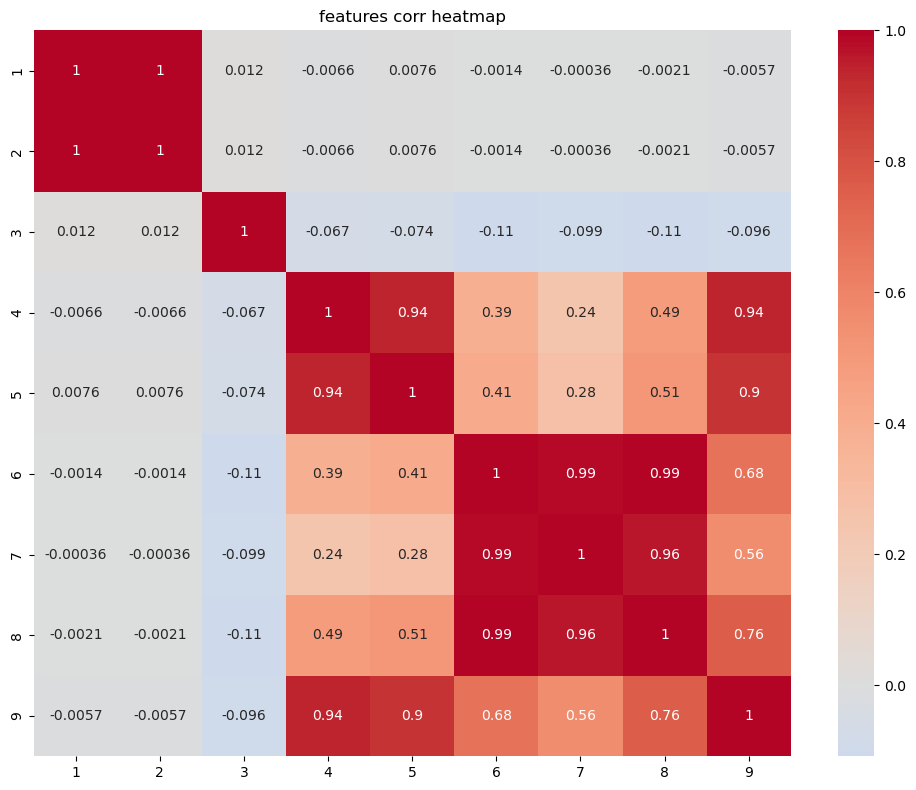

In [11]:
corr_matrix = x.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('features corr heatmap')
plt.tight_layout()
plt.show()

## Set up Regression model

### Train and test split

In [12]:
x_train, x_val, y_train, y_val = train_test_split(input_features, input_labels, train_size = 0.8, shuffle = True, random_state = 2019)

### PCA decomposition

In [13]:
pca = PCA(n_components = 200)
y_train_reduced = pca.fit_transform(y_train)

### Set up XGBoost Regression model

In [14]:
xgbr = XGBRegressor(
    objective = "reg:squarederror", 
    n_estimators = 300, 
    max_depth = 6, 
    learning_rate = 0.01,
    subsample = 0.7,
    colsample_bytree = 1.0
)

In [15]:
# xgbr.fit(x_train, y_train)
xgbr.fit(x_train, y_train_reduced)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Model evaluation

In [16]:
predictions_reduced = xgbr.predict(x_val)
predictions = pca.inverse_transform(predictions_reduced)
# predictions = xgbr.predict(x_val)
mse = mean_squared_error(predictions, y_val)
r2 = r2_score(predictions, y_val)

print("MSE: ", mse)
print("R^2: ", r2)

MSE:  0.5059150446907609
R^2:  -0.3795426871729489


### Compare predictions to actural values

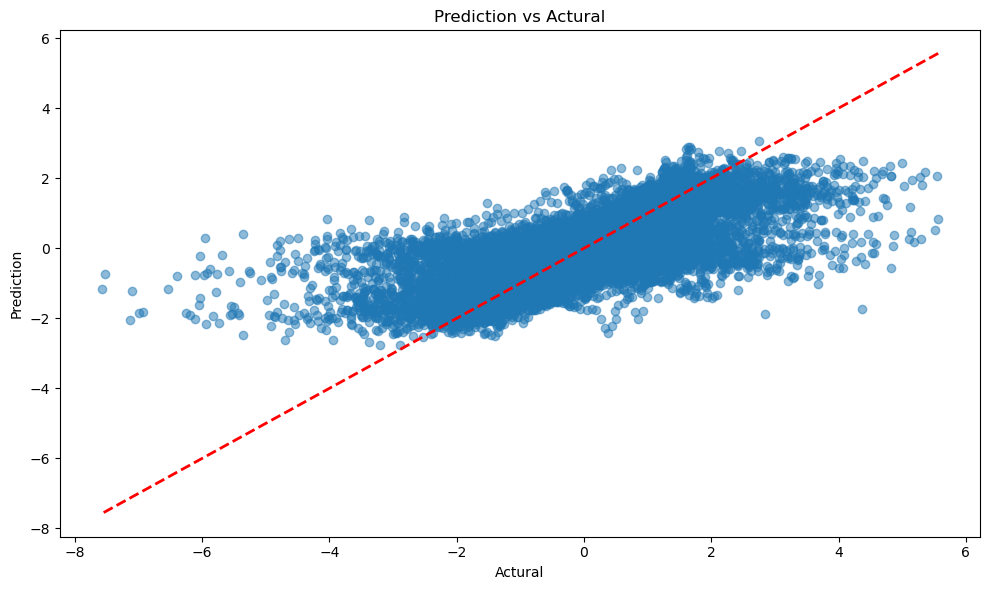

In [14]:
# Compare actural values with prediction
plt.figure(figsize = (10, 6))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([y_val.max(), y_val.min()], [y_val.max(), y_val.min()], 'r--', lw=2)

# Set graph config
plt.xlabel('Actural'); plt.ylabel('Prediction'); plt.title('Prediction vs Actural')
plt.tight_layout()
plt.show()